<a href="https://colab.research.google.com/github/ymourilab/mouri/blob/master/almost_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fbcotter/pytorch_wavelets
!pip install ./pytorch_wavelets/.

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 836, done.
remote: Total 836 (delta 0), reused 0 (delta 0), pack-reused 836
Receiving objects: 100% (836/836), 6.67 MiB | 5.24 MiB/s, done.
Resolving deltas: 100% (584/584), done.
Processing ./pytorch_wavelets
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.1.0-cp36-none-any.whl size=46100 sha256=8863d67f7603a581231f646743f291b1fa1673f7b735af142ef9f6862e0e8626
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_h0o_bv/wheels/82/e1/5b/16a4e6ccfc0bb2ce14bd2796adb13e6e9b718cb7d2e1ae3643
Successfully built pytorch-wavelets


In [2]:
!git clone https://github.com/zh217/torch-dct
!pip install ./torch-dct/.

Cloning into 'torch-dct'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (108/108), 20.64 KiB | 587.00 KiB/s, done.
Resolving deltas: 100% (47/47), done.
Processing ./torch-dct
  Created wheel for torch-dct: filename=torch_dct-0.1.5-cp36-none-any.whl size=4997 sha256=29b353449bf5110401b959c079c0fbbe3fa028de6ce7dc9213e271e19385901f
  Stored in directory: /root/.cache/pip/wheels/54/af/7d/bfc942607a03ab314a2c757dae2f27d25d9698e9ed106890ed
Successfully built torch-dct


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%ls gdrive/My\ Drive/mouri

almost_ok.ipynb     ok.ipynb                         uista.ipynb
cloned-repo/        sample_F.wav                     Untitled0.ipynb
coa_5k_F.wav        sample.wav                       卒研用.gdoc
coa_5k.wav          sample_W.wav                     打ち合わせ資料/
coa_5k_W.wav        test_dct_wavelet.ipynb           毛利卒論.gdoc
Haion_recognition/  try_uISTA_for_lung_sounds.ipynb


In [5]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.3.1
True
cuda


In [17]:
import torch_dct as tdct
from pytorch_wavelets import DWTForward, DWTInverse
import torch

class uISTA(torch.nn.Module):

    def __init__(self, num_unroll, l=1.0, w_l=1., scale=1., prox=None, wt=None, iwt=None):
        super(uISTA, self).__init__()
        self.num_unroll = num_unroll #unroll回数
        #self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=True)#fhみたいなのに変更する
        self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True).to(device=device)#なんか配列作ってる多分なんかの計算用theta
        self.l = self.l * self.l
        self.w_l = torch.nn.Parameter(torch.FloatTensor([w_l]), requires_grad=True).to(device=device)#なんか配列作ってる多分なんかの計算用theta
        self.w_l = self.w_l * self.w_l
        print("l",self.l.type(),self.l.size(),self.l)
        self.scale = scale#thetaの計算に使ってる
        print(self.scale)
        print(device)
        if prox is None:
            self.prox = lambda z, th: z.sign() * (z.abs_() - th).max(torch.tensor(0, device=device).float())
            #zの値を0か負(=-1)か正(=1)か判定したやつとsoft閾値処理したやつの乗算
        else:
            self.prox = prox

        if wt is None:
            self.wt = DWTForward(J=3,wave='db10',mode='zero')
        else:
            self.wt = wt

        if iwt is None:
            self.iwt = DWTInverse(wave='db10', mode='zero')
        else:
            self.iwt = iwt

    def forward(self, b):
        theta = torch.mul(self.l, self.scale)#lの要素をscale倍するらしい
        w_theta = torch.mul(self.w_l, self.scale).div(100)
        print("w_theta",w_theta.type(),w_theta.size(),w_theta)
        # prox(A.dot(b*scale), theta) for initial guess of x xの初期値を決めるよ
        #x = self.prox(b.mul(self.scale).matmul(self.A), theta)    #matmulをidctにidwtに
        #x = self.prox(self.tidct(b.mul_(self.scale)), theta)
        x = self.prox(self.tdct(b.mul_(self.scale)), theta)
        plt.subplot(3,1,1)
        plt.plot(torch.arange(0,len(x[0])).cpu(),x[0].cpu().detach().numpy())
        print(1111111)
        #coeffs = self.dwt(b.reshape(1,1,1,-1))
        w = self.w_softshrink(self.dwt(b.reshape(b.size()[0],1,1,-1)), w_theta)
        plt.subplot(3,1,2)
        plt.plot(torch.arange(0,w[0].size()[3]).cpu(),w[0][0][0][0].cpu().detach().numpy())
        print("理想",type(w),self.dwt(b.reshape(b.size()[0],1,1,-1))[0].size())
        print("b",type(b),b.size(),b.size()[0])
        print("w[0]",w[0].size(),"1",[i.size() for i in w[1]])
        #self.dwt(w)[0].mul_(self.scale),[i.mul_(self.scale)for i in self.dwt(w)[1]])
        #w = self.w_softshrink(self.idwt(self.idwt(self.dwt(b.reshape(1,1,1,-1)))), theta)
        #w = torch.zeros(1,1,1,len(b[0]))
        #w = b.reshape(b.size()[0],1,1,-1)
        #print(x.size(),w.size())
        for i in range(self.num_unroll):
            #x = prox(x+A.T.dot(b-A.dot(x))*scale, theta) ISTAの繰り返し部分
            #x = soft(x + AT(b - Ax))scale
            #x = self.prox(x + (b - x.matmul(self.A.t())).mul_(self.scale).matmul(self.A), theta)
            #x = self.prox(x + r.mul_(self.scale).matmul(self.A), theta)  r = b-Ax
            #x = self.prox(x + At(r*scale), theta)
            x = self.prox(x + self.tdct(b - self.tidct(x)).mul_(self.scale), theta)
            print(i)
            print('after f')
            print("w",w[0].shape,[i.shape for i in w[1]])
            print("ato")
            #[x * y for (x, y) in zip(li1, li2)]
            #+ self.dwt(b.reshape(b.size()[0],1,1,-1) - self.idwt(w).mul_(self.scale))[0],\
            w = self.w_softshrink((w[0] \
                                   ,[v - u.mul_(self.scale) for (v, u) in zip(w[1], self.dwt(b.reshape(b.size()[0],1,1,-1) - self.idwt(w))[1])]), w_theta)
            print("koeta")
        return x,w

    #関数AとATのかわり
    def tdct(self,x):
        return tdct.dct(x)
    
    def tidct(self,x):
        return tdct.idct(x)

    def dwt(self,x):
        return self.wt(x)

    def idwt(self,x):
        return self.iwt((x[0],x[1]))

    def w_softshrink(self,x,th):
        print("soft",type(x),x[0].size())
        return self.prox(x[0],th),[self.prox(i,th) for i in x[1]]

#    def add_b_iwt(self,x,b):
#        for i in range(x[0].size()[0]):
#            b[i][0][0] - self.idwt(w)[i][0][0].mul_(self.scale)
#        return x
"""
    #%% sign function compatible with complex values
    def sgn(z):
        return torch.div(z, z.abs())

    #%% soft thresholding function compatible with complex values
    def f_softshrink(z, th):
        return sgn(z) * torch.max(z.abs() - th, torch.tensor([0]).float())
        """

'\n    #%% sign function compatible with complex values\n    def sgn(z):\n        return torch.div(z, z.abs())\n\n    #%% soft thresholding function compatible with complex values\n    def f_softshrink(z, th):\n        return sgn(z) * torch.max(z.abs() - th, torch.tensor([0]).float())\n        '

In [0]:
softm = lambda z, th: z.sign() * torch.max(z.abs() - th, torch.tensor([0]).float())

In [0]:
def read_file(filename):
    #read
    if os.path.exists(filename + '.wav') == False:
        Fs, input_data  = swf.read(filename + '.WAV')
    else:
        Fs, data = swf.read(filename + '.wav')
    
    #normalize between -1 and 1, change dtype double
    data = data.astype(np.float64)
    plt.subplot(3,1,1)
    plt.plot(np.arange(0,len(data)),data)
    data = data / 32768.0
    print(Fs)
    print(data.shape)
    #plt.subplot(3,1,2)
    #plt.plot(np.arange(0,len(data)),data)
    return Fs,data

5000
(237333,)


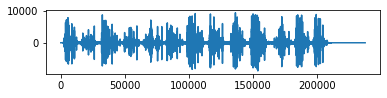

In [20]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from time import time
import os
import scipy.io.wavfile as swf

a = read_file('./gdrive/My Drive/mouri/coa_5k')[1]
a = np.concatenate((a,np.zeros(262144-len(a))),axis=0)
data = torch.arange(0,len(a))

In [21]:
input_data = torch.from_numpy(a).view(1,-1)
print(input_data.size())
print(type(input_data))


torch.Size([1, 262144])
<class 'torch.Tensor'>


torch.Size([1, 262144])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


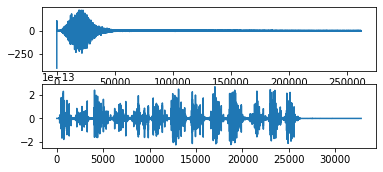

In [22]:
input_data = torch.tensor(input_data, dtype=torch.float).to(device=device)
print(input_data.size())
x = tdct.dct(input_data)
plt.subplot(3,1,1)
plt.plot(torch.arange(0,len(x[0])).cpu(),x[0].cpu().detach().numpy())
wt = DWTForward(J=3,wave='db10',mode='zero')
w = wt(input_data.reshape(input_data.size()[0],1,1,-1))
plt.subplot(3,1,2)
plt.plot(torch.arange(0,w[0].size()[3]).cpu(),w[0][0][0][0].cpu().detach().numpy())
#true

In [23]:
model = uISTA(40).to(device=device)
model.cuda()
print(model.named_parameters())
print(model.parameters())

l torch.cuda.FloatTensor torch.Size([1]) tensor([1.], grad_fn=<MulBackward0>)
1.0
cuda
<generator object Module.named_parameters at 0x7fd6e01ef518>
<generator object Module.parameters at 0x7fd6e01ef518>


In [24]:
print('Is model parameters on GPU? :', next(model.parameters()).is_cuda)
for param in model.parameters():
    print(type(param.data), param.size(), ', is_cuda:', param.is_cuda)

Is model parameters on GPU? : True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True


w_theta torch.cuda.FloatTensor torch.Size([1]) tensor([0.0100], grad_fn=<DivBackward0>)
1111111
soft <class 'tuple'> torch.Size([1, 1, 16, 32784])


RuntimeError: ignored

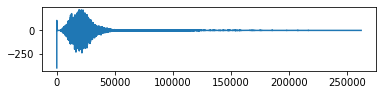

In [25]:
model_out = model.forward(input_data)

In [0]:
j = 0
print("スパース解xをつかって求めた波形\n",tdct.idct(model_out[0][j]))
print("xの結果\n",model_out[0][j])
print("元のフーリエ(x)\n",tdct.dct(input_data[j]))
check = tdct.idct(model_out[0][j]) * 32768.0
print(type(check))
plt.subplot(3,1,1)
plt.title("true")
plt.plot(data.cpu(),input_data[j].cpu() * 32768.0)
plt.subplot(3,1,2)
plt.title("reconst")
plt.plot(data.cpu(),check.cpu().detach().numpy())
plt.subplot(3,1,3)
plt.title("after x")
plt.plot(data.cpu(),model_out[0][j].cpu().detach().numpy())

In [0]:
wt = DWTForward(J=3,wave='db10',mode='zero')
iwt = DWTInverse(wave='db10', mode='zero')

print(type(model_out[1]))
print(type(model_out[1][0]),model_out[1][0].size())
print(type(model_out[1][1]),[x.size() for x in model_out[1][1]])
print(model_out[1][0][0][0][0])
print("確認",wt(input_data[j].reshape(1,1,1,-1))[0].size(),wt(input_data[j].reshape(1,1,1,-1))[0][0][0][0])
#print("wの結果",type(model_out[1]),model_out[1].size(),'\n',model_out[1][j][0][0])
print("スパース解wをつかって求めた波形\n",iwt(model_out[1])[j][0][0] * 32768.0)


check = iwt(model_out[1]) * 32768.0
print(type(check),check.size())
plt.subplot(2,1,1)
plt.plot(data.cpu(),input_data[j].cpu() * 32768.0)
plt.subplot(2,1,2)
plt.plot(data.cpu(),check[j][0][0].cpu().detach().numpy())
